In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string


In [2]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 #1 extra for eol marker


In [3]:
def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


In [4]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


In [5]:
print(unicodeToAscii('k$$%kk'))

kkk


In [6]:
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)


In [7]:
print(n_categories,all_categories)

18 ['Greek', 'Irish', 'Chinese', 'Arabic', 'French', 'Vietnamese', 'Japanese', 'English', 'Scottish', 'Polish', 'Korean', 'Italian', 'Czech', 'German', 'Portuguese', 'Russian', 'Spanish', 'Dutch']


In [8]:
category_lines['Greek']

['Adamidis',
 'Adamou',
 'Agelakos',
 'Akrivopoulos',
 'Alexandropoulos',
 'Anetakis',
 'Angelopoulos',
 'Antimisiaris',
 'Antipas',
 'Antonakos',
 'Antoniadis',
 'Antonopoulos',
 'Antonopoulos',
 'Antonopoulos',
 'Arvanitoyannis',
 'Avgerinos',
 'Banos',
 'Batsakis',
 'Bekyros',
 'Belesis',
 'Bertsimas',
 'Bilias',
 'Blades',
 'Bouloukos',
 'Brisimitzakis',
 'Bursinos',
 'Calogerakis',
 'Calpis',
 'Chellos',
 'Christakos',
 'Christodoulou',
 'Christou',
 'Chrysanthopoulos',
 'Chrysanthopoulos',
 'Comino',
 'Close',
 'Close',
 'Close',
 'Close',
 'Close',
 'Close',
 'Close',
 'Close',
 'Dalianis',
 'Danas',
 'Dasios',
 'Demakis',
 'Demarchis',
 'Demas',
 'Demetrious',
 'Dertilis',
 'Diakogeorgiou',
 'Dioletis',
 'Dounias',
 'Dritsas',
 'Drivakis',
 'Eatros',
 'Egonidis',
 'Eliopoulos',
 'Forakis',
 'Fotopoulos',
 'Fourakis',
 'Frangopoulos',
 'Galanopoulos',
 'Garofalis',
 'Gavril',
 'Gavrilopoulos',
 'Georgeakopoulos',
 'Geracimos',
 'Gianakopulos',
 'Giannakopoulos',
 'Giannakos',
 '

In [29]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size,hidden_size)
        self.i2o = nn.Linear(n_categories+input_size+hidden_size,output_size)
        self.o2o = nn.Linear(hidden_size + output_size,output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self,category,input,hidden):
        input_combined = torch.cat((category,input,hidden),1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        
        output_combined = torch.cat((hidden,output),1)
        output = self.o2o(output_combined)
        output = self.dropout(self.softmax(output))
        
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)
    

In [30]:
import random

def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category,line

In [31]:
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1,n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)-1] = 1
    return tensor

def targetTensor(line):
    letter_idx = [all_letters.find(line[li]) for li in range(1,len(line))]
    letter_idx.append(n_letters-1)
    return torch.LongTensor(letter_idx)


In [32]:
g = categoryTensor('English')
#print(g)
h = inputTensor('Hello')
#print(h.shape)
print(inputTensor('hello there general kenobi'))
print(h.shape)
print(h.unsqueeze(-1).shape)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([5, 1, 59])
torch.Size([5, 1, 59, 1])


In [33]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor


In [34]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)


In [35]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



In [36]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


0m 14s (5000 5%) 2.2051
0m 32s (10000 10%) 2.4041
0m 46s (15000 15%) 2.7894
0m 59s (20000 20%) 2.5509
1m 12s (25000 25%) 1.5614
1m 26s (30000 30%) 3.0248
1m 39s (35000 35%) 2.7963
1m 52s (40000 40%) 2.2700
2m 6s (45000 45%) 2.1674
2m 19s (50000 50%) 3.1239
2m 32s (55000 55%) 0.6779
2m 52s (60000 60%) 1.8334
3m 14s (65000 65%) 2.4767
3m 36s (70000 70%) 1.4357
3m 59s (75000 75%) 2.3366
4m 21s (80000 80%) 2.2647
4m 44s (85000 85%) 2.6974
5m 6s (90000 90%) 3.5907
5m 29s (95000 95%) 2.9580
5m 51s (100000 100%) 2.6511


In [ ]:
import numpy as np
x = np.array([[1,2,3],[4,5,6]])
x = torch.tensor(x)



In [ ]:
y = torch.tensor([[7,8,9],[10,11,12]])
z = torch.cat([x,y],dim = 1)

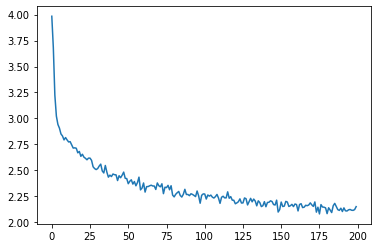

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()


In [39]:
def sample(category,start_letter='A'):
    with torch.no_grad():
        cat_tensor = categoryTensor(category)
        ip = inputTensor(start_letter)
        
        hidden = rnn.initHidden()
        op = start_letter
        
        for i in range(28):
            out,hidden = rnn(cat_tensor,ip[0],hidden)
            topv,topi = output.topk(1)
            
            topi = topi[0][0]
            
            if topi == n_letters - 1:
                break
            
            else:
                letter = all_letters[topi]
                op += letter
            
            ip = inputTensor(letter)
        
        return op
    

In [40]:
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))


In [43]:
samples('Russian','RUS')

RDDDDDDDDDDDDDDDDDDDDDDDDDDDD
UDDDDDDDDDDDDDDDDDDDDDDDDDDDD
SDDDDDDDDDDDDDDDDDDDDDDDDDDDD


In [ ]:
#LOL needs better modelling